# Mapping targeted in-situ technologies to genome-scale espression maps

## Motivation

Unlike spot-based spatial transcriptomics, targeted in-situ technologies (such as MERFISH, smFISH, or seqFISH+) are not limited in their spatial resolution but gene throughput, typically limited to a few hundreds of preselected genes. As a consequence, we face the orthogonal problem of increasing resolution with respect to genes instead of increasing spatial resolution and identifying cellular features. Hence, we would like to impute genes that are measured in scRNA-seq but not in FISH-based technologies.

## Constructing a map between technologies

A method that is widely applicable in the context of aligning spatial profiling measurements with common sc/snRNA-seq profiles is Tangram. While Tangram can also be applied in the previously described deconvolution context, we focus on its ability to map MERFISH data to whole genome expression profiles. The underlying idea of Tangram is the probabilistic alignment of two different technologies by means of a single shared modality, typically RNA-seq data. This way, limitation with respect to the number of genes that are measured or spatial resolution can be overcome. 

## Using Tangram in practise

### Environment setup

In [6]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import tangram as tg

### General settings

In [8]:
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.0 scipy==1.5.2 pandas==1.2.0 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
squidpy==1.2.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the data

In [9]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

In [11]:
adata_st.obs.head(5)

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_MT,log1p_total_counts_MT,pct_counts_MT,n_counts,leiden,cluster
AAATGGCATGTCTTGT-1,1,13,69,5191,8.554874,15977.0,9.678968,20.629655,26.757213,34.743694,48.889028,0.0,0.0,0.0,15977.0,0,Cortex_1
AACAACTGGTAGTTGC-1,1,28,42,5252,8.566555,16649.0,9.720165,20.481711,26.277855,34.092138,48.201093,0.0,0.0,0.0,16649.0,0,Cortex_1
AACAGGAAATCGAATA-1,1,15,67,6320,8.751633,23375.0,10.059465,17.929412,23.850267,32.077005,45.963636,0.0,0.0,0.0,23375.0,0,Cortex_1
AACCCAGAGACGGAGA-1,1,15,39,3659,8.205218,9229.0,9.130215,25.939972,31.964460,39.885145,53.212699,0.0,0.0,0.0,9229.0,1,Cortex_2
AACCGTTGTGTTTGCT-1,1,12,64,4512,8.414717,12679.0,9.447782,21.839262,28.038489,36.209480,50.540263,0.0,0.0,0.0,12679.0,0,Cortex_1


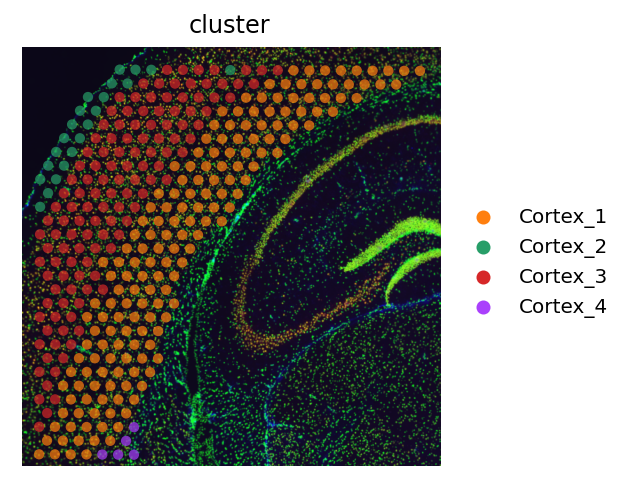

In [12]:
sc.pl.spatial(adata_st, color="cluster", alpha=0.7, frameon=False)

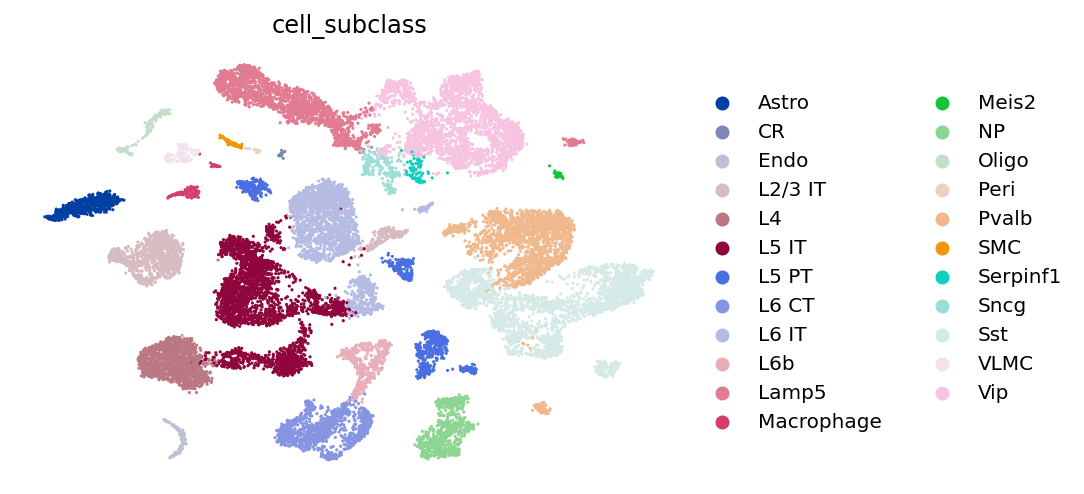

In [13]:
sc.pl.umap(adata_sc, color="cell_subclass", size=10, frameon=False)

### Specifying training genes

We want to select our training genes. These genes are shared between the two datasets and should capture the biological variance between cell types. For this, we first compute marker genes on the single-cell data and then use Tangram's preprocessing function to subset to those genes that are also present in the spatial data.

In [15]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

`tg.pp_adatas` does the following: 
- Computes the overlap between single-cell data and spatial data on the list of genes provided in the `genes` argument
- Stores the resulting gene set under `'training_genes'` in both adata objects under the `.uns` key
- Enforces consitent ordering of the genes
- To reduce potential naming errors gene names are converted to lower case. To prevent this behaviour set ` gene_to_lowercase = False`.

In [16]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Let us check that the function performs as we expect:

In [22]:
assert 'training_genes' in adata_sc.uns
assert 'training_genes' in adata_st.uns

print(f"Number of training_genes: {len(adata_sc.uns['training_genes'])}")

Number of training_genes: 1280


### Computing the map from single-cells to spatial voxels

Having specified the training genes, we can now create the map from dissociated single-cell measurements to the spatial locations. For this, we are going to use the `maps_cells_to_space` function from tangram. This function has two different modes, `mode='cells'` and `mode='clusters'`. The latter only maps averaged single-cells which makes computationally faster and more robust when mapping between specimen. However, as we are interested in imputing our spatial data, we will rely on the cell mode which might require access to a GPU for reasonable runtime.

In [25]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",                                       
    density_prior='rna_count_based',
    num_epochs=500,
    device='cuda', # or: cpu
)
# For the cluster version, you not only have to change the mode, 
# but also provide the `.obs` key which defines the clusters in the single-cell data
# In our case, this would be:

#  mode="clusters"
#  cluster_label='cell_subclass',  # .obs field w cell types

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 10 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.644, KL reg: 0.000
Score: 0.667, KL reg: 0.000
Score: 0.686, KL reg: 0.000
Score: 0.700, KL reg: 0.000
Score: 0.712, KL reg: 0.000
Score: 0.721, KL reg: 0.000
Score: 0.726, KL reg: 0.000
Score: 0.730, KL reg: 0.000
Score: 0.732, KL reg: 0.000
Score: 0.733, KL reg: 0.000
Score: 0.734, KL reg: 0.000
Score: 0.735, KL reg: 0.000
Score: 0.735, KL reg: 0.000
Score: 0.735, KL reg: 0.000
Score: 0.735, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg

INFO:root:Saving results..


Score: 0.737, KL reg: 0.000


The resulting `ad_map` is itself an adata object. Let us inspect it:

In [27]:
ad_map

AnnData object with n_obs × n_vars = 21697 × 324
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

We observe that Tangram's mapping from cell i to spatial voxels j is stored in the `.X` property of `ad_map`

Hence, the meaning of the `.var` and `.obs` also changes: 
- in `.var` have the available metadata of the spatial data, `adata_st`
- in `.obs` have the available metadata of the single-cell data, `adata_sc`

In addition, the information about the training run is stored in the `.uns` key, see `.uns['training_genes_df']` and `.uns[training_history]`.

### Imputing genes and mapping cell-types to space

We can use this result in two ways. First, we can map the cell type information that was originally only present in the single-cell data to space. This an easy way to check that your results are biologically consistent by looking for known cell type patterns. Second, we can investigate the spatial gene-expression of those genes that have not been measured with the in-situ method in the first place, effectively imputing all the missing genes.

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


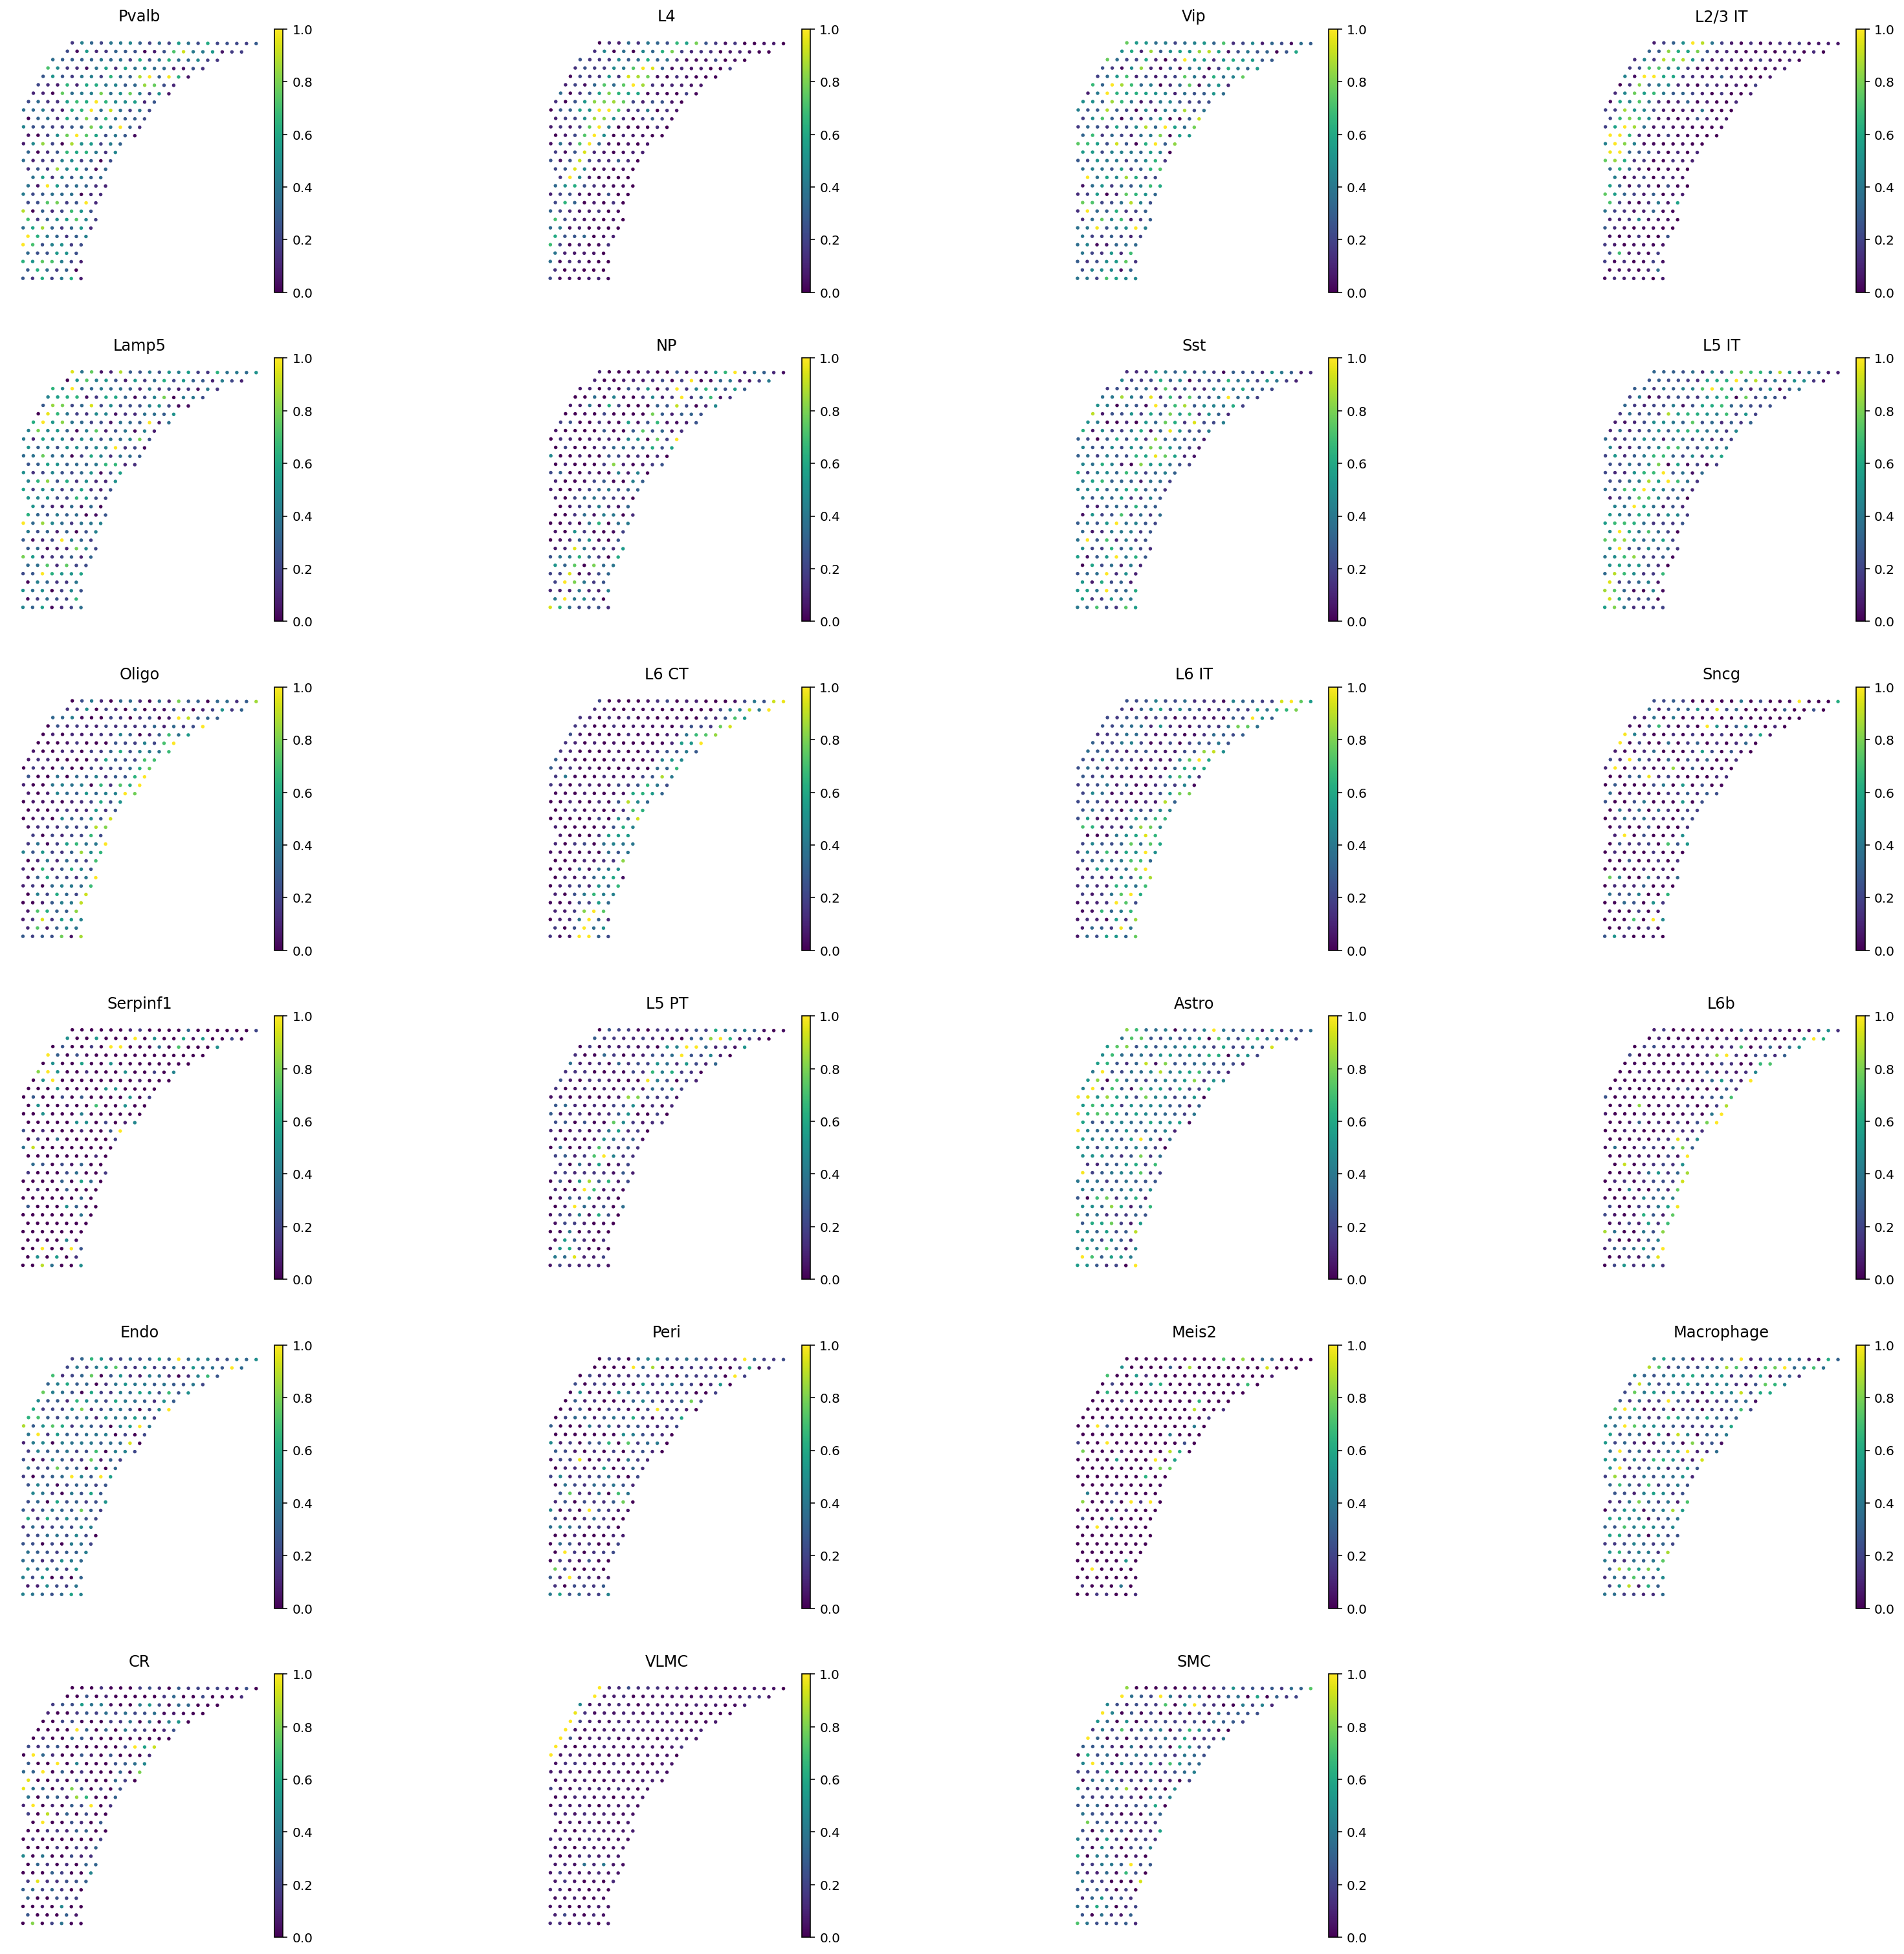

In [35]:
# Project the cell annotation to spatial locations
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))

# Plot the spatial annotation
# The `perc` argument steers the range of the colourmap and can help with removing outliers.
tg.plot_cell_annotation_sc(adata_st, annotation_list,perc=0.02, spot_size=100)

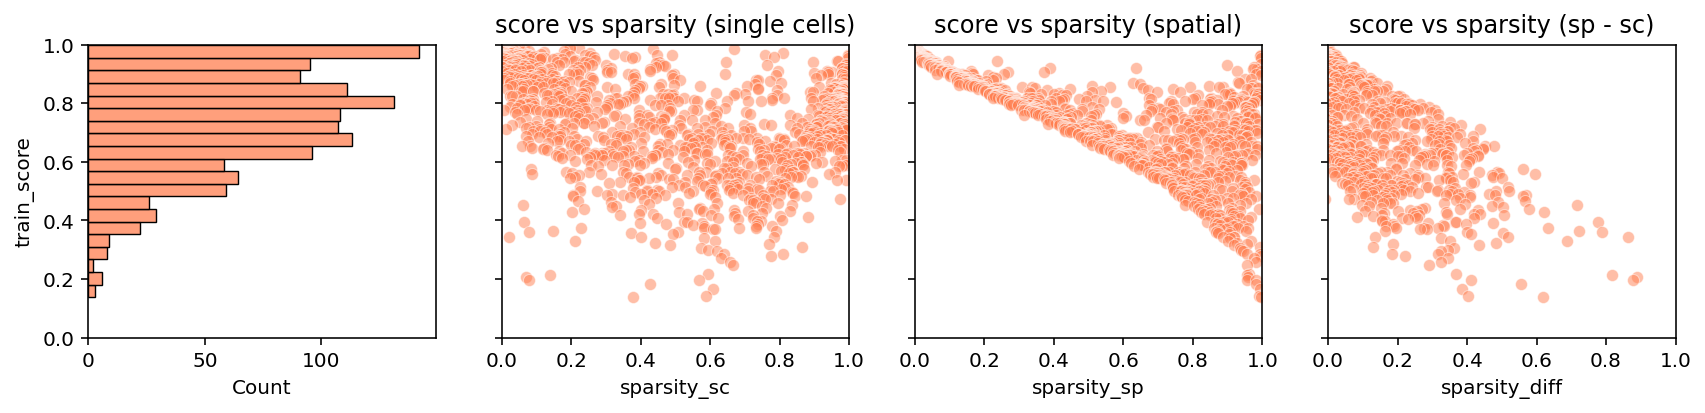

In [31]:
#  To get a deeper sense, Tangram also computes several scores, which are readily plotted
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

The score generally measures the similarity between original measurement (by the spatial technology) and the inferred mapping by single-cell data. The middle panels both relate the sparsity of the respective data, single-cell and spatial, of a training genes (each dot is a training gene) with the achieved score. As you can see, the performance is much more correlated with the spatial data which is often more sparse and therefore responsible for low-quality mappings. The last panel sets both technologies in context. Genes that have similar sparsity levels in both spatial and single-cell data usually achieve better scores than those that are inconsistent across technologies. 

Minor remark: The similarity that Tangram builds on is cosine similarity.

Even more detailed information can be found in the `.uns["train_genes_df"]`.

To genes new spatial data, we can project the genes present in the single-cell data to the spatial locations. This is easily achieved by multiplying the mapping matrix stored in `ad_map` with the original single-cell data stored in `adata_sc`. Tangram already provides a convenience function which takes in a mapping and the corresponding single-cell data. The result is a spatial voxel by genes matrix which technically is identical to the original spatial data `adata_st` but contains expression values for all genes.

In [32]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'training_genes', 'overlap_genes'

Next, we will compare the new spatial data with the orignial measurments. This will provide us with a better feeling why some training scores might be bad. Note that this explicit mapping of Tangram relies relies on entirely different premises than those in probabilistic models. Here, we are inclined to trust the predicted gene expression patterns based on the godd mapping performance of most training genes. The fact the some genes show a very sparse and dispersed spatial signal can be understood a result of technical dropout of the spatial technology rather than a shortcoming of the mapping method.

In [37]:
genes = ['rragb', 'trim17', 'eno1b']
ad_map.uns['train_genes_df'].loc[genes]

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
rragb,0.359481,0.079919,0.867284,0.787365
trim17,0.205170,0.069641,0.959877,0.890236
eno1b,0.343538,0.022492,0.885802,0.863311


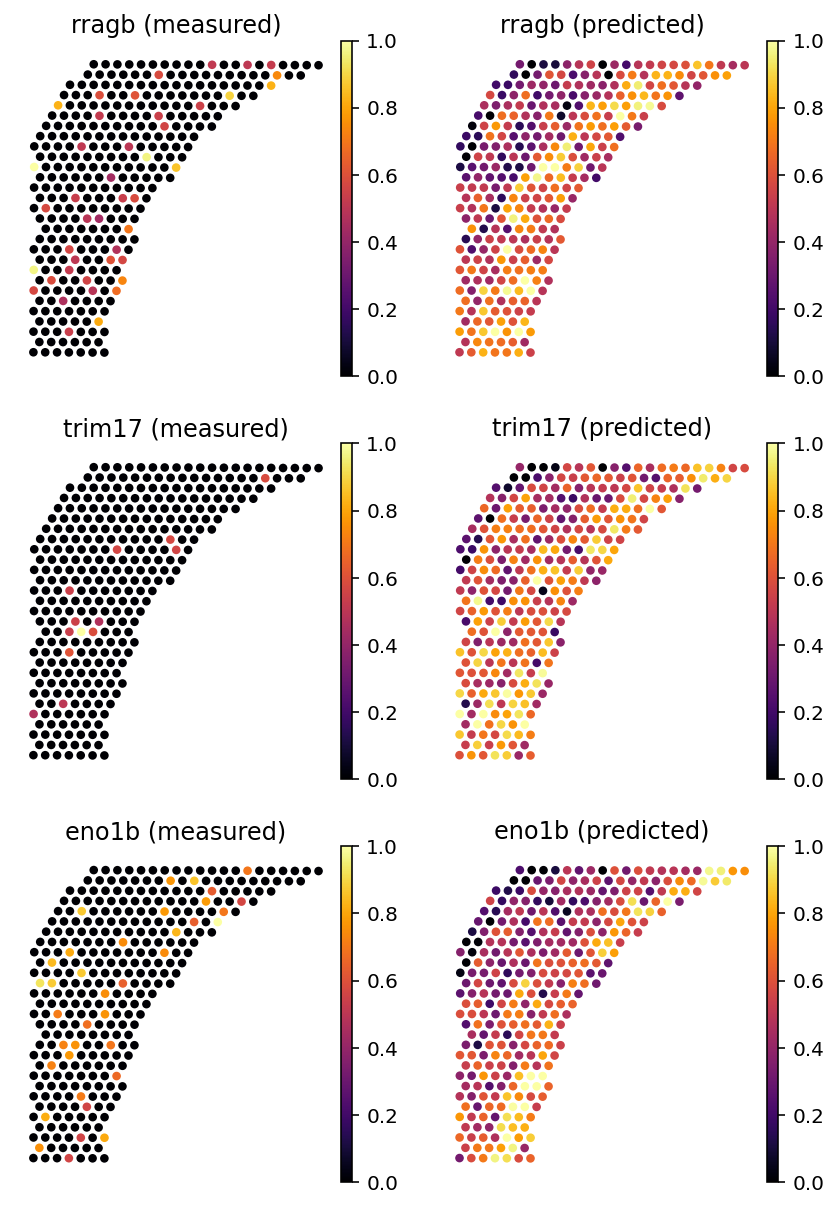

In [39]:
# The comparison between original measurements on predicted ones is easily done with tangram

tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02, spot_size=200)

#### Plotting genes that were not part of the training data

We can also inspect genes there were part of the training genes but not detected in the spatial data

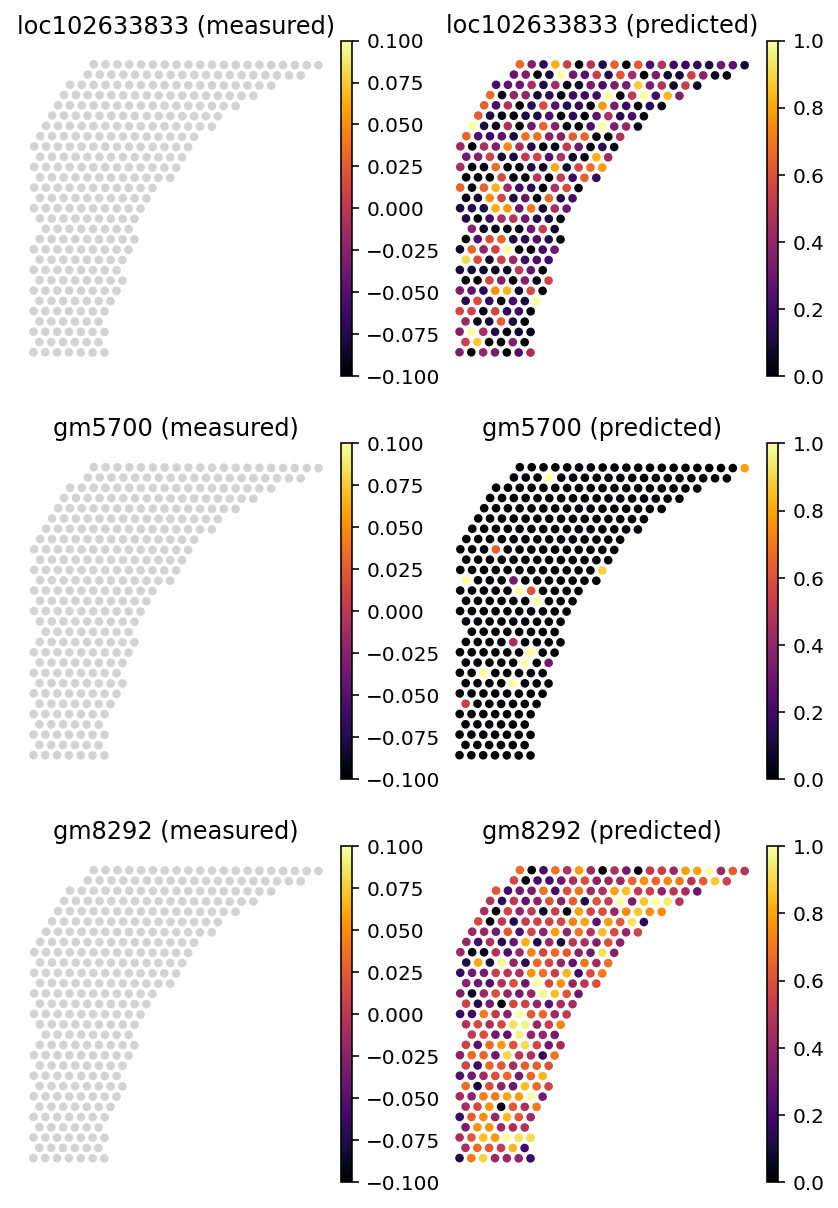

In [41]:
genes=['loc102633833', 'gm5700', 'gm8292']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02, spot_size=200)

In [ ]:
# For targeted assays one can also compare those genes that were not used for training 
# For this use `compare spatial_genexp`
# >>> df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
# >>> df_all_genes

# Every gene gets a score 
# Most important validation is spatial sparsity vs. score 
# >>> tg.plot_auc(df_all_genes)

# This leads to different notions
# Sparse but localised -> Tangram infers consistent posistions
# >>> genes=['tfap2b', 'zic4']
# >>> tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)
# Non-Sparse but accentuated thhrough Tangram
# >>> genes = ['cd34', 'rasal1']
# >>> tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)